<h1 align="left">Multi-investment Attribution: Distinguish the Effects of Multiple Outreach Efforts</h1>

<img src="https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Attribution.png" width="400">

A software company would like to know whether its multiple outreach efforts to their business customers are successful in boosting sales. They would also like to learn how to better target different incentives to different customers. In other words, they would like to learn the **treatment effect** of each investment on customers' total expenditure on the company’s products: particularly the **heterogeneous treatment effect**. 

In an ideal world, the company would run experiments where each customer would receive a random assortment of investments. However, this approach can be logistically prohibitive or strategically unsound: the company might not have the resources to design such experiments or they might not want to risk major revenue losses by randomizing their incentives to top customers.

In this notebook, we show how tools from the [Causica](https://github.com/microsoft/causica), [EconML](https://aka.ms/econml) and [DoWhy](https://github.com/py-why/dowhy) libraries can use historical investment data to learn the effects of multiple investments.

For this exercise, we create simulated data that recreates some key characteristics of real data from a software company facing this type of decision. Simulating data protects the company’s privacy. Because we create the data, we are also in the unusual position of knowing the true causal graph and true effects of each investments, so we can compare the results of our estimation to this ground truth.

In the next section, we introduce this simulated data. We then use Causica to discover the causal graph, the relationship between each variable in the simulated data. With this generated graph, we use DoWhy to identify an appropriate strategy to estimate the causal effect. We pass this recommendation to EconML to estimate the personalized treatment effects for each customer. We also show an alternative effect estimation using Causica. Finally, we use EconML to map these estimated effects into suggested investment strategies for each customer, and DoWhy to test the assumptions underlying the causal estimation.

## Environment Setup
It might be necessary to install `graphviz` and `pygraphviz` for improved visualisations of the graphs. Please refer to [this](https://github.com/py-why/dowhy#installation) for more information.

For Ubuntu with poetry, run
```
sudo apt-get install graphviz libgraphviz-dev
```

You can then follow the instructions [here](https://github.com/microsoft/causica#poetry) to set up poetry and install the environment with
```
poetry install --with pygraphviz
```
The poetry environment will install all required packages.

### Outline

1. [Data](#Data)
2. [Discover Causal Graph](#Discover-Causal-Graph)
3. [Identify Causal Strategy](#Identify-Causal-Strategy)
4. [Estimate Treatment Effects](#Estimate-Treatment-Effects)
5. [Test Estimate Robustness](#Test-Estimate-Robustness)
6. [Make Policy Recommendations](#Make-Policy-Recommendations)
7. [Appendix](#Appendix)

In [2]:
# Some imports to get us started
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Utilities
import os
import json
import urllib.request
import numpy as np
import pandas as pd
from difflib import get_close_matches
from scipy.special import expit 

# Generic ML imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso

# EconML imports
from econml.dml import LinearDML
from econml.cate_interpreter import SingleTreePolicyInterpreter

# DoWhy imports 
import dowhy
from dowhy import CausalModel 
import dowhy.gcm

# Causica imports
from causica.models.deci.deci import DECI
from causica.datasets.dataset import Dataset
from causica.datasets.variables import Variables

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

%matplotlib inline

# Data

The simulated dataset contains 10,000 customers. 

We create one outcome of interest:

Feature Name | Type | Details 
:--- |:--- |:--- 
**Revenue** | continuous | \\$ Annual revenue from customer given by the amount of software purchased

We consider three possible treatments, the interventions whose impact we wish to measure:

Feature Name | Type | Details 
:--- |:--- |:--- 
**Tech Support** | binary | whether the customer received tech support during the year
**Discount** | binary | whether the customer was given a discount during the year
**New Strategy** | binary | whether the customer was targeted for a new engagement strategy with different outreach behaviors

Finally, we consider a variety of additional customer characteristics that may affect revenue. Including these types of features is crucial for causal analysis in order to map the full causal graph and separate the true effects of treatments on outcomes from other correlation generated by other influences. 

Feature Name | Type | Details 
:--- |:--- |:--- 
**Global Flag** | binary | whether the customer has global offices
**Major Flag** | binary | whether the customer is a large consumer in their industry (as opposed to SMC - Small Medium Corporation - or SMB - Small Medium Business)
**SMC Flag** | binary | whether the customer is a Small Medium Corporation (SMC, as opposed to major and SMB)
**Commercial Flag** | binary | whether the customer's business is commercial (as opposed to public secor)
**Planning Summit** | binary | whether a sales team member held an outreach event with the customer during the year
**New Product Adoption** | binary | whether the customer signed a contract for any new products during the year
**IT Spend** | continuous | \\$ spent on IT-related purchases 
**Employee Count** | continuous | number of employees
**PC Count** | continuous | number of PCs used by the customer
**Size** | continuous | customer's total revenue in the previous calendar year

In simulating the data, we maintain some key characteristics of the data from the real company example, including some correlation patterns between features and some potentially difficult data characteristics, such as large outliers.

#### Import the Simulated Data

In [3]:
# Import the sample multi-attribution data
file_url = "https://azuastoragepublic.blob.core.windows.net/datasets/causal_ai_suite/multi_attribution_data_20220819.csv"
multi_data = pd.read_csv(file_url)

In [4]:
# Data sample
print('Data Shape:', multi_data.shape)
multi_data.head()

Data Shape: (10000, 20)


,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,New Engagement Strategy,New Product Adoption,Planning Summit,Revenue,Direct Treatment Effect: Tech Support,Total Treatment Effect: Tech Support,Direct Treatment Effect: Discount,Total Treatment Effect: Discount,Direct Treatment Effect: New Engagement Strategy,Total Treatment Effect: New Engagement Strategy
0,0,0,1,1,72490,27,25,220417,1,0,0,1,0,39691.32,9408.34,10332.57,11020.85,11020.85,0,0
1,0,0,1,0,5985,19,12,12510,1,0,1,1,1,14492.54,5250.20,6174.43,625.50,625.50,0,0
2,0,0,1,0,34399,82,55,123530,0,0,0,0,0,16215.76,7470.60,8394.83,6176.50,6176.50,0,0
3,0,1,1,1,29705,103,58,79297,0,1,1,1,1,25426.04,6585.94,7510.17,3964.85,3964.85,0,0
4,0,0,1,1,13498,60,26,25472,1,0,1,1,1,21005.51,5509.44,6433.67,1273.60,1273.60,0,0


#### Import the Ground Truth Causal Effects

Unlike most real-world causal use cases, in this case we know the true causal relationships between treatments and outcome because we have simulated the data. We also extract those effects, created during data generation, to check our later causal effect estimates.

In [5]:
ground_truth_effects = multi_data.loc[:, 'Direct Treatment Effect: Tech Support':] # extract ground truth effects
multi_data = multi_data.loc[:, 'Global Flag': 'Revenue'] # remove ground truth from dataframe

In [6]:
# Load metadata telling us the data type of each column
with open("multi_attribution_data_20220819_data_types.json") as f:
    variables = json.load(f)

# Discover Causal Graph

In [5]:
# Set up data in a suitable form for DECI to consume, using the loaded data types
numpy_data = multi_data.to_numpy()
data_mask = np.ones(numpy_data.shape)
variables = Variables.create_from_data_and_dict(numpy_data, data_mask, variables)
dataset = Dataset(train_data=numpy_data, train_mask=np.ones(numpy_data.shape), variables=variables)

Minimum value of variable Global Flag inferred as 0. This can be changed manually in the dataset's variables.json file
Max value of variable Global Flag inferred as 1. This can be changed manually in the dataset's variables.json file
Variable Global Flag inferred to be a queriable variable. This can be changed manually in the dataset's variables.json file by updating the "query" field.
Variable Global Flag inferred as not an active learning target variable. This can be changed manually in the dataset's variables.json file by updating the "target" field.
Variable Global Flag inferred as an always observed target variable. This can be changed manually in the dataset's variables.json file by updating the "always_observed" field.
Minimum value of variable Major Flag inferred as 0. This can be changed manually in the dataset's variables.json file
Max value of variable Major Flag inferred as 1. This can be changed manually in the dataset's variables.json file
Variable Major Flag inferred to 

### Creating and training DECI model

The following snippets step through the process of:
 - configuring and creating a DECI model
 - training a model with no graph constraints
 - training a model with graph constraints
 
*Note*: if you have already trained a DECI model, you can reload the model by skipping to the section below on "Loading a saved DECI model"

#### DECI configuration

The DECI model has a number of hyperparameters, but attention need not be paid to all of them. Here we highlight key hyperparameters that might be changed to improve performance:
 - `learning_rate` is the step size for the Adam optimizer. Decrease the learning rate if training is unstable
 - `var_dist_A_learning_rate` is the learning rate for the causal graph distribution
 - `standardize_data_mean` and `standardize_data_std` tell DECI to standarize the data by subtracting the mean and dividing by the standard deviation of each column. *Note*: this improves training, but you need to take care because treatment effects will now be computed in this standardized space
 - `max_auglag_inner_epochs` is the number of gradient steps taken in each "inner step" of the DECI optimization. Decrease this to speed up training (at the risk of training not converging). Increase this to learn a more accurate model, or when the dataset is larger.
 - `max_steps_auglag` is the maximum number of "inner steps" taken. Decrease this to end training early (e.g. before a DAG has been found) to speed up training
 - `base_distribution_type` is the type of DECI model that is trained. It should be either `gaussian` or `spline`. Use `spline` for highly non-Gaussian data, or to fit a better density model of the observational data.
 
Other hyperparameters are less frequently changed.

In [6]:
# DECI configurations
model_config = {
    "tau_gumbel": 0.25,
    "lambda_dag": 10.0,
    "lambda_sparse": 1.0,
    "lambda_prior": 0.0,
    # Choosing a Gaussian DECI model, alternative is "spline"
    "base_distribution_type": "gaussian",
    "imputation": False,
    "spline_bins": 8,
    "var_dist_A_mode": "enco",
    "mode_adjacency": "learn",
}

training_params = {
    # Setting higher learning rates can speed up training, but risks some instability
    "learning_rate": 1e-3,
    "var_dist_A_learning_rate": 1e-2,
    "batch_size": 512,
    # This standarizes the data before training. The DECI model operates in standardized space.
    "standardize_data_mean": True,
    "standardize_data_std": True,
    "rho": 1.0,
    "safety_rho": 1e18,
    "alpha": 0.0,
    "safety_alpha": 1e18,
    "tol_dag": 1e-9,
    "progress_rate": 0.65,
    # We are setting this large to wait until we find a DAG
    "max_steps_auglag": 200,
    # We are setting this large to learn a more accurate model.
    "max_auglag_inner_epochs": 2000,
    "max_p_train_dropout": 0.0,
    "reconstruction_loss_factor": 1.0,
    "anneal_entropy": "noanneal",
}

In [7]:
deci_save_directory = "causica_deci_model"
# We recommend gpu training
device = "gpu"
model = DECI.create("mymodel", deci_save_directory, dataset.variables, model_config, device=device)

In [59]:
model.run_train(dataset, training_params)

Saving logs to causica_deci_model/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 12.23, log p(x|A): -12.23, dag: 5.56881875, log p(A)_sp: -0.00, log q(A): -0.008, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00231, cts_mse_icgnn: 4.28
Inner Step: 200, loss: 10.50, log p(x|A): -10.49, dag: 11.07477377, log p(A)_sp: -0.00, log q(A): -0.008, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00834, cts_mse_icgnn: 3.01
Inner Step: 300, loss: 9.62, log p(x|A): -9.62, dag: 12.73339411, log p(A)_sp: -0.00, log q(A): -0.008, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0102, cts_mse_icgnn: 2.47
Inner Step: 400, loss: 9.20, log p(x|A): -9.20, dag: 13.60129872, log p(A)_sp: -0.00, log q(A): -0.007, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0115, cts_mse_icgnn: 2.32
Inner Step: 500, loss: 8.78, log p(x|A): -8.77, dag: 15.03115698, log p(A)_sp: -0.00, log q(A): -0.007, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0145, cts_mse_icgnn: 2.1
Inner 

Inner Step: 700, loss: 5.82, log p(x|A): -5.80, dag: 14.34944656, log p(A)_sp: -0.00, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0113, cts_mse_icgnn: 1.36
Inner Step: 800, loss: 5.64, log p(x|A): -5.63, dag: 15.24197502, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0127, cts_mse_icgnn: 1.32
Inner Step: 900, loss: 5.70, log p(x|A): -5.69, dag: 15.38411249, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0132, cts_mse_icgnn: 1.35
Inner Step: 1000, loss: 5.64, log p(x|A): -5.63, dag: 15.21374117, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0124, cts_mse_icgnn: 1.34
Inner Step: 1100, loss: 5.47, log p(x|A): -5.46, dag: 16.00282013, log p(A)_sp: -0.01, log q(A): -0.002, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0139, cts_mse_icgnn: 1.28
Inner Step: 1200, loss: 5.67, log p(x|A): -5.65, dag: 15.45925512, log p(A)_sp: -0.01, l

Inner Step: 1300, loss: 5.16, log p(x|A): -5.13, dag: 12.81269665, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0287, cts_mse_icgnn: 1.21
Inner Step: 1400, loss: 5.14, log p(x|A): -5.11, dag: 13.27857042, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.03, cts_mse_icgnn: 1.2
Inner Step: 1500, loss: 5.12, log p(x|A): -5.08, dag: 12.94650284, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.029, cts_mse_icgnn: 1.2
Inner Step: 1600, loss: 5.12, log p(x|A): -5.08, dag: 12.75088198, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0285, cts_mse_icgnn: 1.21
Inner Step: 1700, loss: 5.12, log p(x|A): -5.09, dag: 12.58752289, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0279, cts_mse_icgnn: 1.19
Inner Step: 1800, loss: 5.21, log p(x|A): -5.18, dag: 12.75214642, log p(A)_sp: -0.01, log

Inner Step: 1900, loss: 5.07, log p(x|A): -5.04, dag: 12.72315535, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0284, cts_mse_icgnn: 1.19
Inner Step: 2000, loss: 5.09, log p(x|A): -5.06, dag: 12.73644072, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0284, cts_mse_icgnn: 1.21
Best model found at innner step 1220, with Loss 4.92
Dag penalty after inner: 12.8342994576
Time taken for this step 17.321857929229736
Unrounded adj matrix:
[[[0.00000000e+00 2.92786479e-01 3.42818499e-01 9.61994827e-01
   3.16479206e-02 9.75400209e-03 3.09407711e-03 1.30983770e-01
   2.24013448e-01 2.59464443e-01 1.79044843e-01 9.97440815e-01
   2.60198712e-02 2.45766640e-02]
  [3.86416912e-04 0.00000000e+00 3.50058079e-04 9.98595417e-01
   1.37156248e-03 1.29854679e-03 1.58751011e-03 1.11931562e-03
   8.94981623e-03 2.97531843e-01 4.31060791e-04 9.97709155e-01
   9.94414687e-01 3.64533663e-02]
  [8.44258070e-03 1.31605864e-

Dag penalty: 11.653820530891419
Rho: 10.00, alpha: 15.72
Auglag Step: 5
LR: 0.001
Inner Step: 100, loss: 5.13, log p(x|A): -5.06, dag: 10.23920914, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0693, cts_mse_icgnn: 1.21
Inner Step: 200, loss: 5.16, log p(x|A): -5.09, dag: 9.76510044, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0635, cts_mse_icgnn: 1.22
Inner Step: 300, loss: 5.12, log p(x|A): -5.05, dag: 9.70983068, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0627, cts_mse_icgnn: 1.21
Inner Step: 400, loss: 5.13, log p(x|A): -5.06, dag: 9.93090963, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0655, cts_mse_icgnn: 1.21
Inner Step: 500, loss: 5.13, log p(x|A): -5.06, dag: 9.92588570, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0655, cts_mse_icgnn: 1.21
Inner Step: 

Inner Step: 700, loss: 5.19, log p(x|A): -5.03, dag: 9.52075619, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.155, cts_mse_icgnn: 1.21
Inner Step: 800, loss: 5.19, log p(x|A): -5.04, dag: 9.23850777, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.149, cts_mse_icgnn: 1.2
Inner Step: 900, loss: 5.18, log p(x|A): -5.03, dag: 9.01327545, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.144, cts_mse_icgnn: 1.2
Reducing lr to 0.00010
Inner Step: 1000, loss: 5.18, log p(x|A): -5.03, dag: 9.03551422, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.145, cts_mse_icgnn: 1.21
Inner Step: 1100, loss: 5.12, log p(x|A): -4.97, dag: 8.97282940, log p(A)_sp: -0.01, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.143, cts_mse_icgnn: 1.2
Inner Step: 1200, loss: 5.13, log p(x|A): -4.99, dag: 8.86210745, log p(A)_sp:

Inner Step: 1300, loss: 5.29, log p(x|A): -4.99, dag: 6.55265770, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.291, cts_mse_icgnn: 1.2
Inner Step: 1400, loss: 5.30, log p(x|A): -5.01, dag: 6.57262966, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.292, cts_mse_icgnn: 1.21
Inner Step: 1500, loss: 5.30, log p(x|A): -5.00, dag: 6.65378092, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.299, cts_mse_icgnn: 1.2
Inner Step: 1600, loss: 5.29, log p(x|A): -5.00, dag: 6.59001984, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.294, cts_mse_icgnn: 1.2
Inner Step: 1700, loss: 5.27, log p(x|A): -4.98, dag: 6.59046301, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.294, cts_mse_icgnn: 1.2
Reducing lr to 0.00001
Inner Step: 1800, loss: 5.29, log p(x|A): -4.99, dag: 6.61027723, log p(A)_s

Inner Step: 1900, loss: 6.22, log p(x|A): -5.13, dag: 4.54988657, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.09, cts_mse_icgnn: 1.23
Inner Step: 2000, loss: 6.21, log p(x|A): -5.12, dag: 4.54201998, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.08, cts_mse_icgnn: 1.23
Best model found at innner step 1860, with Loss 6.11
Dag penalty after inner: 4.8433483162
Time taken for this step 17.43467664718628
Unrounded adj matrix:
[[[0.00000000e+00 1.89449728e-01 3.53536427e-01 9.98218238e-01
   2.47930765e-01 3.26253176e-02 2.45887041e-03 2.62493789e-01
   3.10388446e-01 3.16172659e-01 2.91561842e-01 9.99603987e-01
   1.78426504e-03 1.00809336e-02]
  [7.06911087e-05 0.00000000e+00 2.49743462e-05 9.99271154e-01
   6.89029694e-05 7.42077827e-05 2.41339207e-04 5.06639481e-05
   1.51276588e-04 1.04963779e-04 5.98430634e-05 9.98585403e-01
   6.76327944e-03 2.37107277e-04]
  [9.41395760e-04 4.62966204e-01 0.000

Dag penalty: 3.894187006950379
Rho: 1000.00, alpha: 4008.37
Auglag Step: 10
LR: 0.001
Inner Step: 100, loss: 6.76, log p(x|A): -5.24, dag: 2.80105921, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.52, cts_mse_icgnn: 1.34
Inner Step: 200, loss: 6.59, log p(x|A): -5.27, dag: 2.49717316, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.32, cts_mse_icgnn: 1.41
Inner Step: 300, loss: 6.63, log p(x|A): -5.35, dag: 2.43074272, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.27, cts_mse_icgnn: 1.42
Inner Step: 400, loss: 6.61, log p(x|A): -5.33, dag: 2.43168365, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.27, cts_mse_icgnn: 1.43
Inner Step: 500, loss: 6.58, log p(x|A): -5.31, dag: 2.41526569, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.26, cts_mse_icgnn: 1.42
Inner Step: 600, lo

Inner Step: 700, loss: 6.78, log p(x|A): -5.41, dag: 1.85003428, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.36, cts_mse_icgnn: 1.55
Reducing lr to 0.00010
Inner Step: 800, loss: 6.74, log p(x|A): -5.37, dag: 1.85808429, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.37, cts_mse_icgnn: 1.55
Inner Step: 900, loss: 6.75, log p(x|A): -5.32, dag: 1.91405617, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.43, cts_mse_icgnn: 1.54
Inner Step: 1000, loss: 6.72, log p(x|A): -5.32, dag: 1.89435297, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.4, cts_mse_icgnn: 1.53
Inner Step: 1100, loss: 6.70, log p(x|A): -5.32, dag: 1.87287884, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.38, cts_mse_icgnn: 1.55
Inner Step: 1200, loss: 6.68, log p(x|A): -5.31, dag: 1.85569690, log p(A)_sp: -0

Inner Step: 1300, loss: 8.24, log p(x|A): -5.32, dag: 1.84969309, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.92, cts_mse_icgnn: 1.54
Inner Step: 1400, loss: 8.22, log p(x|A): -5.33, dag: 1.83940348, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.88, cts_mse_icgnn: 1.54
Inner Step: 1500, loss: 8.19, log p(x|A): -5.32, dag: 1.83274921, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.87, cts_mse_icgnn: 1.54
Inner Step: 1600, loss: 8.25, log p(x|A): -5.35, dag: 1.83866452, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.89, cts_mse_icgnn: 1.55
Inner Step: 1700, loss: 8.26, log p(x|A): -5.30, dag: 1.86603195, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.96, cts_mse_icgnn: 1.54
Reducing lr to 0.00001
Inner Step: 1800, loss: 8.18, log p(x|A): -5.31, dag: 1.82937591, log p(A)_sp

Inner Step: 1900, loss: 6.51, log p(x|A): -6.43, dag: 0.02687634, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0822, cts_mse_icgnn: 1.96
Inner Step: 2000, loss: 6.51, log p(x|A): -6.43, dag: 0.02520871, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0798, cts_mse_icgnn: 1.94
Best model found at innner step 1940, with Loss 6.35
Dag penalty after inner: 0.4983836322
Time taken for this step 17.47637391090393
Unrounded adj matrix:
[[[0.00000000e+00 2.48245180e-01 1.70212209e-01 9.99627948e-01
   1.73667133e-01 3.30163479e-01 2.91562080e-03 1.52148604e-02
   3.42301250e-01 3.04729223e-01 1.64217174e-01 9.99767959e-01
   4.95731831e-04 2.46759176e-01]
  [2.14576721e-05 0.00000000e+00 5.24520874e-06 9.99696553e-01
   2.35438347e-05 9.23871994e-06 2.78353691e-05 2.68220901e-06
   1.59144402e-04 3.89814377e-05 1.43647194e-05 9.99293387e-01
   2.12788582e-04 1.56760216e-05]
  [1.41859055e-04 4.39247131e-01 0

Dag penalty: 0.018780726909637
Rho: 100000.00, alpha: 8316.59
Auglag Step: 15
LR: 0.001
Inner Step: 100, loss: 6.41, log p(x|A): -6.40, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.96
Inner Step: 200, loss: 6.45, log p(x|A): -6.43, dag: 0.00670938, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0197, cts_mse_icgnn: 1.96
Inner Step: 300, loss: 6.51, log p(x|A): -6.42, dag: 0.02090630, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0933, cts_mse_icgnn: 1.95
Inner Step: 400, loss: 6.44, log p(x|A): -6.43, dag: 0.00166764, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00278, cts_mse_icgnn: 1.96
Inner Step: 500, loss: 6.44, log p(x|A): -6.40, dag: 0.01008348, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0338, cts_mse_icgnn: 1.97
Reducing lr

Inner Step: 700, loss: 6.48, log p(x|A): -6.35, dag: 0.00504174, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.131, cts_mse_icgnn: 1.96
Inner Step: 800, loss: 6.33, log p(x|A): -6.33, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 900, loss: 6.49, log p(x|A): -6.36, dag: 0.00504174, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.131, cts_mse_icgnn: 1.96
Inner Step: 1000, loss: 6.35, log p(x|A): -6.33, dag: 0.00166764, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0153, cts_mse_icgnn: 1.96
Inner Step: 1100, loss: 6.35, log p(x|A): -6.34, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.96
Inner Step: 1200, loss: 6.33, log p(x|A): -6.32, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H

Inner Step: 1400, loss: 6.16, log p(x|A): -6.14, dag: 0.00166764, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0162, cts_mse_icgnn: 1.95
Inner Step: 1500, loss: 6.27, log p(x|A): -6.13, dag: 0.00504173, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.134, cts_mse_icgnn: 1.95
Inner Step: 1600, loss: 6.13, log p(x|A): -6.13, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1700, loss: 6.14, log p(x|A): -6.14, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1800, loss: 6.15, log p(x|A): -6.15, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1900, loss: 6.25, log p(x|A): -6.11, dag: 0.00504173, log p(A)_sp: -0.00, log q(A): -0.001, H 

Inner Step: 2000, loss: 6.05, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Best model found at innner step 1840, with Loss 5.97
Dag penalty after inner: 0.0072886553
Time taken for this step 17.470842361450195
Unrounded adj matrix:
[[[0.00000000e+00 2.02003717e-01 1.66592419e-01 9.99663949e-01
   8.77236724e-02 2.38754809e-01 2.39363909e-02 1.09028816e-03
   3.24682534e-01 2.31272280e-01 3.56423616e-01 9.99827981e-01
   8.96692276e-04 2.26246119e-01]
  [2.18153000e-05 0.00000000e+00 5.96046448e-07 9.99832630e-01
   1.77025795e-05 1.16825104e-05 5.68628311e-05 1.25169754e-06
   2.32118368e-03 5.89549541e-04 7.80820847e-06 9.99639690e-01
   9.13143158e-05 1.07884407e-05]
  [1.24275684e-04 9.92083430e-01 0.00000000e+00 2.07896829e-01
   6.03075027e-01 2.41028845e-01 8.20017457e-01 4.05550003e-04
   9.99732673e-01 9.94753242e-01 3.06633472e-01 5.41746616e-03
   4.11722064e-02 9.88789797e-0

Dag penalty: 0.004913060188293
Rho: 10000000.00, alpha: 13956.14
Auglag Step: 20
LR: 0.001
Inner Step: 100, loss: 6.05, log p(x|A): -6.05, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.86
Inner Step: 200, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.86
Inner Step: 300, loss: 6.25, log p(x|A): -6.11, dag: 0.00166764, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.141, cts_mse_icgnn: 1.87
Inner Step: 400, loss: 6.03, log p(x|A): -6.03, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 500, loss: 6.02, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 600, loss: 6.

Reducing lr to 0.00010
Inner Step: 700, loss: 36.37, log p(x|A): -5.94, dag: 0.02463688, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 30.4, cts_mse_icgnn: 1.87
Inner Step: 800, loss: 7.18, log p(x|A): -5.89, dag: 0.00504173, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.29, cts_mse_icgnn: 1.86
Inner Step: 900, loss: 35.30, log p(x|A): -5.89, dag: 0.02421589, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 29.4, cts_mse_icgnn: 1.85
Inner Step: 1000, loss: 5.89, log p(x|A): -5.89, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.86
Inner Step: 1100, loss: 5.90, log p(x|A): -5.89, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 1200, loss: 5.88, log p(x|A): -5.88, dag: 0.00000000, log p(A)_sp: -0.00

Inner Step: 1300, loss: 5.91, log p(x|A): -5.91, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.9
Inner Step: 1400, loss: 5.90, log p(x|A): -5.90, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.88
Inner Step: 1500, loss: 5.90, log p(x|A): -5.90, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.89
Inner Step: 1600, loss: 5.90, log p(x|A): -5.90, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.89
Inner Step: 1700, loss: 5.91, log p(x|A): -5.91, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.89
Reducing lr to 0.00001
Inner Step: 1800, loss: 5.90, log p(x|A): -5.90, dag: 0.00000000, log p(A)_sp: -0.00, log q(A

Inner Step: 2000, loss: 5.90, log p(x|A): -5.90, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.89
Best model found at innner step 1720, with Loss 5.84
Dag penalty after inner: 0.0024593906
Time taken for this step 16.692113161087036
Unrounded adj matrix:
[[[0.00000000e+00 2.87667155e-01 5.38824201e-02 9.99785483e-01
   2.77481675e-02 2.82645643e-01 1.43926740e-02 8.47518444e-04
   3.66112709e-01 1.12596989e-01 4.68609095e-01 9.99838710e-01
   1.08826160e-03 9.04005170e-02]
  [1.15036964e-05 0.00000000e+00 1.19209290e-07 9.99841928e-01
   2.74181366e-06 9.59634781e-06 2.19345093e-05 2.98023224e-07
   1.33067489e-01 1.53303146e-04 2.20537186e-06 9.99653161e-01
   5.32269478e-05 1.20401382e-05]
  [1.72734261e-04 9.98801291e-01 0.00000000e+00 1.09739184e-01
   4.00640965e-01 2.72350073e-01 9.44297314e-01 2.98880339e-02
   9.99847174e-01 9.98428702e-01 2.36689448e-01 1.39284134e-03
   1.45566761e-01 9.95335281e-0

Dag penalty: 0.004491886615753
Rho: 10000000000.00, alpha: 34887.31
Auglag Step: 25
LR: 0.001
Inner Step: 100, loss: 9917.53, log p(x|A): -5.98, dag: 0.01407942, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 9.91e+03, cts_mse_icgnn: 1.9
Inner Step: 200, loss: 6.01, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.93
Inner Step: 300, loss: 5.99, log p(x|A): -5.99, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.9
Inner Step: 400, loss: 6.00, log p(x|A): -5.99, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.92
Inner Step: 500, loss: 1276.96, log p(x|A): -5.99, dag: 0.00504173, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.27e+03, cts_mse_icgnn: 1.92
Inner St

Inner Step: 700, loss: 92.79, log p(x|A): -5.97, dag: 0.00041668, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 86.8, cts_mse_icgnn: 1.91
Inner Step: 800, loss: 410560.39, log p(x|A): -6.02, dag: 0.03324970, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 4.11e+05, cts_mse_icgnn: 1.92
Inner Step: 900, loss: 14914.12, log p(x|A): -6.03, dag: 0.00546041, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.49e+04, cts_mse_icgnn: 1.94
Reducing lr to 0.00010
Inner Step: 1000, loss: 5.95, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.93
Inner Step: 1100, loss: 557215.41, log p(x|A): -5.94, dag: 0.03338291, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 5.57e+05, cts_mse_icgnn: 1.92
Inner Step: 1200, loss: 12715.49, log p(x|A): -5.93, dag

Inner Step: 1300, loss: 1835511.11, log p(x|A): -5.93, dag: 0.01957203, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.84e+06, cts_mse_icgnn: 1.93
Inner Step: 1400, loss: 5.94, log p(x|A): -5.93, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.93
Inner Step: 1500, loss: 5.94, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.93
Inner Step: 1600, loss: 5.95, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.93
Inner Step: 1700, loss: 1334365.23, log p(x|A): -5.92, dag: 0.01633621, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.33e+06, cts_mse_icgnn: 1.94
Inner Step: 1800, loss: 5.96, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log

Inner Step: 1900, loss: 8687.05, log p(x|A): -5.96, dag: 0.00041668, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 8.68e+03, cts_mse_icgnn: 1.94
Inner Step: 2000, loss: 5.98, log p(x|A): -5.98, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Best model found at innner step 1240, with Loss 5.88
Dag penalty after inner: 0.0035270376
Time taken for this step 16.66501522064209
Unrounded adj matrix:
[[[0.00000000e+00 1.39645517e-01 1.95629597e-02 9.99800861e-01
   1.16748810e-02 7.11666942e-02 4.98067737e-02 3.58641148e-04
   1.99956000e-01 5.35222888e-02 3.45393777e-01 9.99907970e-01
   3.06665897e-04 1.64976120e-02]
  [1.54376030e-05 0.00000000e+00 2.38418579e-07 9.98303890e-01
   5.69224358e-05 4.27544117e-04 5.32865524e-05 3.15904617e-06
   4.91831303e-02 5.96046448e-05 2.86102295e-06 9.99854803e-01
   2.09212303e-05 1.17421150e-05]
  [2.13801861e-04 9.99173224e-01 0

Dag penalty: 0.000568082809448
Rho: 10000000000000.00, alpha: 5680862981.79
Auglag Step: 30
LR: 0.001
Inner Step: 100, loss: 6.02, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 200, loss: 6.03, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 300, loss: 6.02, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 400, loss: 6.02, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 500, loss: 6.02, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 600, l

Inner Step: 700, loss: 6.03, log p(x|A): -6.03, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 800, loss: 8923.81, log p(x|A): -6.01, dag: 0.00041668, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 8.92e+03, cts_mse_icgnn: 1.95
Inner Step: 900, loss: 6.06, log p(x|A): -6.05, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1000, loss: 5904921.15, log p(x|A): -6.01, dag: 0.01086163, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 5.9e+06, cts_mse_icgnn: 1.95
Inner Step: 1100, loss: 6.02, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1200, loss: 6.01, log p(x|A): -6.01, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): 

Inner Step: 1400, loss: 5.95, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Reducing lr to 0.00001
Inner Step: 1500, loss: 5.95, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1600, loss: 5.97, log p(x|A): -5.97, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1700, loss: 5.94, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1800, loss: 5.95, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 1900, loss: 5.93, log p(x|A): -5.93, dag: 0.00000000, log p(A)_sp: -0.00, log q(

Dag penalty: 0.001629243850708
Rho: 1000000000000000.00, alpha: 28404314908.94
Auglag Step: 34
LR: 0.001
Inner Step: 100, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 200, loss: 6.05, log p(x|A): -6.05, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 300, loss: 6.03, log p(x|A): -6.03, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 400, loss: 6.01, log p(x|A): -6.01, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 500, loss: 6.00, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Reducing lr to 

Inner Step: 700, loss: 6.02, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Reducing lr to 0.00010
Inner Step: 800, loss: 6.00, log p(x|A): -5.99, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 900, loss: 5.95, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 1000, loss: 5.94, log p(x|A): -5.93, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.93
Inner Step: 1100, loss: 5.95, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.96
Inner Step: 1200, loss: 5.95, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A):

Reducing lr to 0.00010
Inner Step: 1400, loss: 5.96, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 1500, loss: 5.94, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1600, loss: 5.95, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 1700, loss: 5.95, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 1800, loss: 5.91, log p(x|A): -5.91, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 1900, loss: 5.94, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(

Dag penalty: 0.000652286529541
Rho: 100000000000000000.00, alpha: 142021574544.71
Auglag Step: 38
LR: 0.001
Inner Step: 100, loss: 6.01, log p(x|A): -6.01, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.96
Inner Step: 200, loss: 5.99, log p(x|A): -5.99, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 300, loss: 6.01, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 400, loss: 6.00, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 500, loss: 5.99, log p(x|A): -5.98, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 

Inner Step: 700, loss: 5.97, log p(x|A): -5.97, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 800, loss: 5.92, log p(x|A): -5.91, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 900, loss: 5.97, log p(x|A): -5.96, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.95
Inner Step: 1000, loss: 5.95, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 1100, loss: 5.93, log p(x|A): -5.93, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.94
Inner Step: 1200, loss: 5.94, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.00

Inner Step: 1400, loss: 5.95, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 1500, loss: 5.96, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 1600, loss: 5.94, log p(x|A): -5.93, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 1700, loss: 5.96, log p(x|A): -5.95, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 1800, loss: 5.95, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 1900, loss: 5.95, log p(x|A): -5.94, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0

Dag penalty: 0.000899396896362
Rho: 1000000000000000000.00, alpha: 3550539363617.86
Auglag Step: 42
LR: 0.001
Inner Step: 100, loss: 5.99, log p(x|A): -5.99, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 200, loss: 5.99, log p(x|A): -5.99, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 300, loss: 6.02, log p(x|A): -6.02, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 400, loss: 5.96, log p(x|A): -5.96, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step: 500, loss: 5.97, log p(x|A): -5.97, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.001, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 1.87
Inner Step

In [60]:
networkx_graph = model.networkx_graph()
variable_name_dict = {i: var.name for (i, var) in enumerate(variables)}

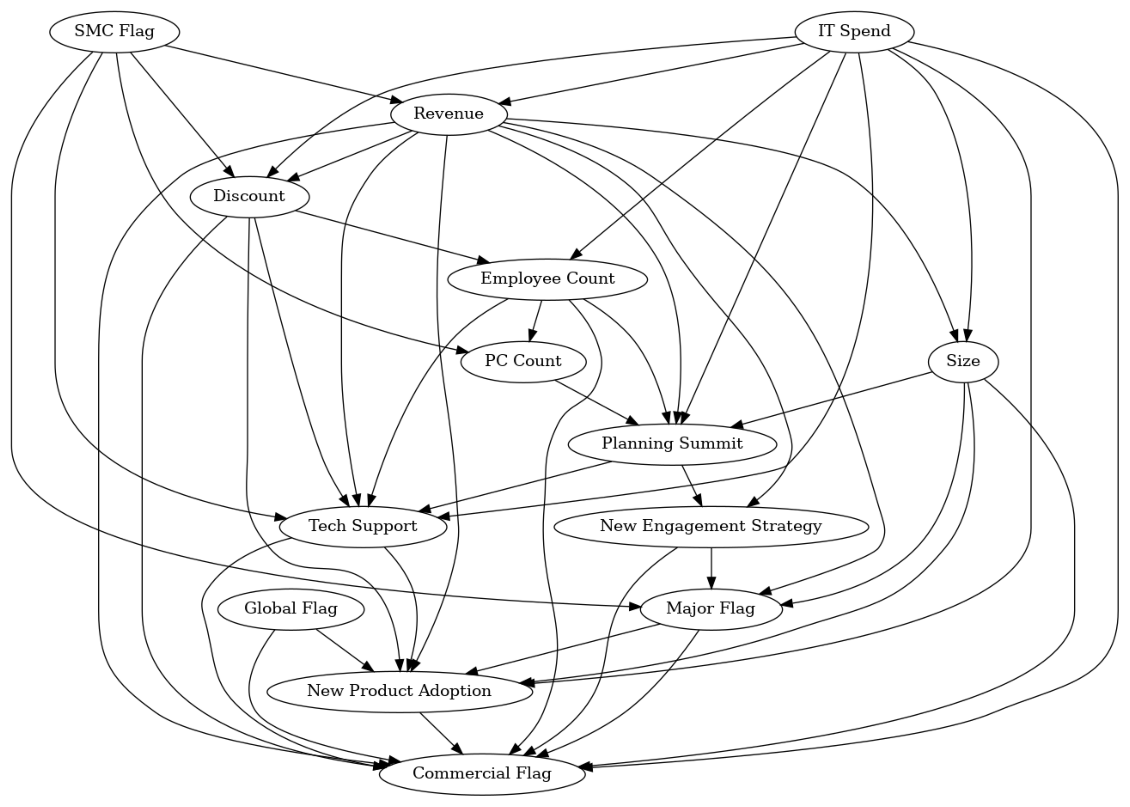

In [61]:
dowhy.gcm.util.plot(nx.relabel_nodes(networkx_graph, variable_name_dict), figure_size=(20,20))

### Adding domain-specific graph constraints
To improve the quality of the learned graph, it is possible to place constraints on the graph that DECI learns. The constraints come in two flavours:
 - *negative constraints* mean a certain edge cannot exist in the graph,
 - *positive constraints* mean a certain edge must exist in the graph.

In [7]:
# Constraint matrix coding is described in the DECI docstrings
# The constraint matrix has the same shape as the adjacency matrix
# A `nan` value means no constraint
# A 0 value means a negative constraint
# A 1 value means a positive constraint

constraint_matrix = np.full((len(dataset.variables), len(dataset.variables)), np.nan, dtype=np.float32)

First, we introduce the constraint that Revenue cannot be the cause of any other node, except possibly Planning Summit.

In [8]:
revenue_idx = dataset.variables.name_to_idx["Revenue"]
planning_summit_idx = dataset.variables.name_to_idx["Planning Summit"]
constraint_matrix[revenue_idx, :] = 0.
constraint_matrix[revenue_idx, planning_summit_idx] = np.nan

Second, we say that certain basic attributes of companies cannot be changed by other variables (at least on the time scale we are considering). The attributes we constraint to have no parents are: Commerical Flag, Major Flag, SMC Flag, PC Count, Employee Count, Global Flag, Size.

In [9]:
non_child_nodes = ['Commercial Flag', 'Major Flag', 'SMC Flag', 'PC Count', 'Employee Count', 'Global Flag', 'Size']
non_child_idxs = [dataset.variables.name_to_idx[name] for name in non_child_nodes]
constraint_matrix[:, non_child_idxs] = 0.

Finally, we make a constraint that says that different engagements do not directly cause one another. For example, giving Tech Support to a company is not a valid reason to give / not give them a Discount.

In [10]:
engagement_nodes = ["Tech Support", "Discount", "New Engagement Strategy"]
engagement_idxs = [dataset.variables.name_to_idx[name] for name in engagement_nodes]
for i in engagement_idxs:
    constraint_matrix[engagement_idxs, i] = 0.

We now create a fresh DECI model and apply the constraints.

In [63]:
model = DECI.create("mymodel", deci_save_directory, dataset.variables, model_config, device=device)
model.set_graph_constraint(constraint_matrix)

In [64]:
model.run_train(dataset, training_params)

Saving logs to causica_deci_model/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 12.42, log p(x|A): -12.43, dag: 0.58085792, log p(A)_sp: -0.00, log q(A): -0.009, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 4.45e-05, cts_mse_icgnn: 4.7
Inner Step: 200, loss: 10.97, log p(x|A): -10.98, dag: 1.75359444, log p(A)_sp: -0.00, log q(A): -0.011, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000301, cts_mse_icgnn: 3.97
Inner Step: 300, loss: 10.23, log p(x|A): -10.24, dag: 2.66317835, log p(A)_sp: -0.00, log q(A): -0.011, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000691, cts_mse_icgnn: 3.67
Inner Step: 400, loss: 9.82, log p(x|A): -9.83, dag: 2.99562043, log p(A)_sp: -0.00, log q(A): -0.011, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000722, cts_mse_icgnn: 3.55
Inner Step: 500, loss: 9.35, log p(x|A): -9.36, dag: 3.36155186, log p(A)_sp: -0.00, log q(A): -0.011, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00084, cts_mse_icgnn: 3.34
I

Inner Step: 1200, loss: 6.69, log p(x|A): -6.70, dag: 3.03739815, log p(A)_sp: -0.00, log q(A): -0.007, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000631, cts_mse_icgnn: 3.16
Inner Step: 1300, loss: 6.84, log p(x|A): -6.84, dag: 3.54916879, log p(A)_sp: -0.00, log q(A): -0.007, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000774, cts_mse_icgnn: 3.16
Inner Step: 1400, loss: 6.59, log p(x|A): -6.59, dag: 3.50889564, log p(A)_sp: -0.00, log q(A): -0.007, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000701, cts_mse_icgnn: 3.15
Inner Step: 1500, loss: 6.92, log p(x|A): -6.92, dag: 3.58968585, log p(A)_sp: -0.00, log q(A): -0.007, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000761, cts_mse_icgnn: 3.16
Inner Step: 1600, loss: 6.97, log p(x|A): -6.97, dag: 3.57233280, log p(A)_sp: -0.00, log q(A): -0.007, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000703, cts_mse_icgnn: 3.14
Inner Step: 1700, loss: 6.48, log p(x|A): -6.48, dag: 3.61723699, log p(A)_sp: -

Dag penalty: 3.456656601428985
Rho: 1.00, alpha: 3.13
Auglag Step: 3
LR: 0.001
Inner Step: 100, loss: 6.31, log p(x|A): -6.31, dag: 3.23027434, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00154, cts_mse_icgnn: 3.13
Inner Step: 200, loss: 6.21, log p(x|A): -6.21, dag: 3.35071963, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00162, cts_mse_icgnn: 3.14
Inner Step: 300, loss: 6.24, log p(x|A): -6.24, dag: 3.25262684, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00155, cts_mse_icgnn: 3.13
Inner Step: 400, loss: 6.17, log p(x|A): -6.17, dag: 3.33226108, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00162, cts_mse_icgnn: 3.13
Inner Step: 500, loss: 6.15, log p(x|A): -6.15, dag: 3.28231004, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00157, cts_mse_icgnn: 3.12
Inner Step:

Reducing lr to 0.00010
Inner Step: 700, loss: 6.17, log p(x|A): -6.16, dag: 3.25232933, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00634, cts_mse_icgnn: 3.12
Inner Step: 800, loss: 6.13, log p(x|A): -6.13, dag: 3.27613637, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00646, cts_mse_icgnn: 3.12
Inner Step: 900, loss: 6.13, log p(x|A): -6.12, dag: 3.24458104, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00644, cts_mse_icgnn: 3.12
Inner Step: 1000, loss: 6.13, log p(x|A): -6.12, dag: 3.28764523, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0065, cts_mse_icgnn: 3.11
Inner Step: 1100, loss: 6.14, log p(x|A): -6.13, dag: 3.22385454, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00629, cts_mse_icgnn: 3.11
Inner Step: 1200, loss: 6.11, log p(x|A): -6.11, dag: 3.21070127, 

Inner Step: 1300, loss: 6.20, log p(x|A): -6.15, dag: 3.23167500, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0535, cts_mse_icgnn: 3.11
Inner Step: 1400, loss: 6.17, log p(x|A): -6.11, dag: 3.26537310, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0549, cts_mse_icgnn: 3.12
Inner Step: 1500, loss: 6.42, log p(x|A): -6.37, dag: 3.17707745, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0516, cts_mse_icgnn: 3.12
Inner Step: 1600, loss: 6.14, log p(x|A): -6.09, dag: 3.19402432, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0527, cts_mse_icgnn: 3.12
Reducing lr to 0.00001
Inner Step: 1700, loss: 6.14, log p(x|A): -6.09, dag: 3.19379841, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0522, cts_mse_icgnn: 3.12
Inner Step: 1800, loss: 6.14, log p(x|A): -6.09, dag: 3.20225229, l

Inner Step: 1900, loss: 6.40, log p(x|A): -6.04, dag: 2.68738114, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.364, cts_mse_icgnn: 3.11
Inner Step: 2000, loss: 6.40, log p(x|A): -6.05, dag: 2.65553854, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.354, cts_mse_icgnn: 3.12
Best model found at innner step 1280, with Loss 6.24
Dag penalty after inner: 2.7274473791
Time taken for this step 16.618813276290894
Unrounded adj matrix:
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   7.86633492e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
   5.26463985e-01 3.81509244e-01 5.48507750e-01 7.27668703e-01
   4.65268791e-01 9.95999932e-01]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   4.11486030e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
   9.96092021e-01 9.93138671e-01 9.98770416e-01 9.37878072e-01
   5.99618196e-01 9.98919308e-01]
  [0.00000000e+00 0.00000000e+00 0.

Dag penalty: 1.216452881336212
Rho: 10000.00, alpha: 3.13
Auglag Step: 8
LR: 0.001
Inner Step: 100, loss: 6.65, log p(x|A): -6.26, dag: 0.88776013, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.396, cts_mse_icgnn: 3.12
Inner Step: 200, loss: 6.68, log p(x|A): -6.29, dag: 0.88260460, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.39, cts_mse_icgnn: 3.12
Inner Step: 300, loss: 6.66, log p(x|A): -6.27, dag: 0.87484645, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.394, cts_mse_icgnn: 3.13
Inner Step: 400, loss: 6.66, log p(x|A): -6.28, dag: 0.84920866, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.383, cts_mse_icgnn: 3.12
Inner Step: 500, loss: 6.66, log p(x|A): -6.27, dag: 0.83223823, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.392, cts_mse_icgnn: 3.12
Inner Step: 600, l

Inner Step: 700, loss: 6.34, log p(x|A): -6.32, dag: 0.02647814, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.022, cts_mse_icgnn: 3.15
Inner Step: 800, loss: 6.34, log p(x|A): -6.32, dag: 0.02816402, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0251, cts_mse_icgnn: 3.15
Inner Step: 900, loss: 6.31, log p(x|A): -6.32, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1000, loss: 6.33, log p(x|A): -6.32, dag: 0.01765209, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0146, cts_mse_icgnn: 3.14
Inner Step: 1100, loss: 6.37, log p(x|A): -6.36, dag: 0.01344662, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00974, cts_mse_icgnn: 3.15
Inner Step: 1200, loss: 6.34, log p(x|A): -6.35, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0

Inner Step: 1400, loss: 6.31, log p(x|A): -6.30, dag: 0.00504174, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00323, cts_mse_icgnn: 3.15
Inner Step: 1500, loss: 6.21, log p(x|A): -6.20, dag: 0.01440277, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.016, cts_mse_icgnn: 3.15
Inner Step: 1600, loss: 6.20, log p(x|A): -6.20, dag: 0.00882605, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00732, cts_mse_icgnn: 3.15
Inner Step: 1700, loss: 6.26, log p(x|A): -6.26, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1800, loss: 6.27, log p(x|A): -6.25, dag: 0.01944451, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0192, cts_mse_icgnn: 3.15
Reducing lr to 0.00001
Inner Step: 1900, loss: 6.21, log p(x|A): -6.20, dag: 0.01086163, log p

Dag penalty: 0.003012913227081
Rho: 10000.00, alpha: 3990.51
Auglag Step: 12
LR: 0.001
Inner Step: 100, loss: 6.28, log p(x|A): -6.26, dag: 0.01440277, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0161, cts_mse_icgnn: 3.15
Inner Step: 200, loss: 6.21, log p(x|A): -6.21, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.15
Inner Step: 300, loss: 6.19, log p(x|A): -6.20, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 400, loss: 6.18, log p(x|A): -6.18, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 500, loss: 6.20, log p(x|A): -6.20, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.15
Inner Step: 600, loss: 6.19,

Inner Step: 700, loss: 6.22, log p(x|A): -6.22, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.15
Reducing lr to 0.00010
Inner Step: 800, loss: 6.18, log p(x|A): -6.18, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 900, loss: 6.13, log p(x|A): -6.13, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1000, loss: 6.27, log p(x|A): -6.26, dag: 0.01086163, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.0103, cts_mse_icgnn: 3.15
Inner Step: 1100, loss: 6.13, log p(x|A): -6.13, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1200, loss: 6.13, log p(x|A): -6.13, dag: 0.00000000, log p(A)_sp: -0.00, log 

Inner Step: 1500, loss: 6.12, log p(x|A): -6.13, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Reducing lr to 0.00001
Inner Step: 1600, loss: 6.22, log p(x|A): -6.11, dag: 0.01440277, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.11, cts_mse_icgnn: 3.14
Inner Step: 1700, loss: 6.11, log p(x|A): -6.11, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1800, loss: 6.12, log p(x|A): -6.12, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1900, loss: 6.12, log p(x|A): -6.12, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 2000, loss: 6.24, log p(x|A): -6.25, dag: 0.00000000, log p(A)_sp: -0.00, log

Dag penalty: 0.001089901983002
Rho: 1000000.00, alpha: 4157.73
Auglag Step: 16
LR: 0.001
Inner Step: 100, loss: 7.22, log p(x|A): -6.18, dag: 0.01440277, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.04, cts_mse_icgnn: 3.15
Inner Step: 200, loss: 6.20, log p(x|A): -6.20, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 300, loss: 6.18, log p(x|A): -6.18, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 400, loss: 6.17, log p(x|A): -6.17, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 500, loss: 6.23, log p(x|A): -6.23, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.15
Inner Step: 600, loss: 6.17,

Inner Step: 700, loss: 7.39, log p(x|A): -6.12, dag: 0.00504174, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.27, cts_mse_icgnn: 3.14
Inner Step: 800, loss: 6.11, log p(x|A): -6.11, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 900, loss: 6.10, log p(x|A): -6.10, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1000, loss: 6.10, log p(x|A): -6.10, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1100, loss: 17.18, log p(x|A): -6.11, dag: 0.02102896, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 11.1, cts_mse_icgnn: 3.14
Inner Step: 1200, loss: 6.11, log p(x|A): -6.11, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H fille

Inner Step: 1400, loss: 6.14, log p(x|A): -6.14, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1500, loss: 6.09, log p(x|A): -6.09, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1600, loss: 6.12, log p(x|A): -6.12, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1700, loss: 6.12, log p(x|A): -6.12, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1800, loss: 6.09, log p(x|A): -6.10, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Reducing lr to 0.00000
Exiting at innner step 1840.
Best model found at innner step 1340, with Loss 6.02
Dag penalt

Dag penalty: 0.000610203689404
Rho: 1000000000.00, alpha: 31558.51
Auglag Step: 20
LR: 0.001
Inner Step: 100, loss: 232.22, log p(x|A): -6.18, dag: 0.00672331, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 226, cts_mse_icgnn: 3.14
Inner Step: 200, loss: 6.17, log p(x|A): -6.17, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 300, loss: 6.18, log p(x|A): -6.18, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.15
Inner Step: 400, loss: 6.16, log p(x|A): -6.17, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 500, loss: 6.16, log p(x|A): -6.16, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.15
Inner Step: 600, loss: 

Inner Step: 800, loss: 6.23, log p(x|A): -6.24, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.15
Inner Step: 900, loss: 6.17, log p(x|A): -6.17, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1000, loss: 6.16, log p(x|A): -6.16, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1100, loss: 6.14, log p(x|A): -6.14, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1200, loss: 6.15, log p(x|A): -6.15, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1300, loss: 6.13, log p(x|A): -6.13, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.0

Inner Step: 1500, loss: 6.14, log p(x|A): -6.14, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Reducing lr to 0.00010
Inner Step: 1600, loss: 6.12, log p(x|A): -6.12, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1700, loss: 6.08, log p(x|A): -6.08, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1800, loss: 6.07, log p(x|A): -6.07, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 1900, loss: 6.09, log p(x|A): -6.09, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 2000, loss: 6.07, log p(x|A): -6.07, dag: 0.00000000, log p(A)_sp: -0.00, log q(

Dag penalty: 0.001263219833374
Rho: 1000000000000.00, alpha: 31558.51
Auglag Step: 24
LR: 0.001
Inner Step: 100, loss: 6.10, log p(x|A): -6.10, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 200, loss: 6.13, log p(x|A): -6.13, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 300, loss: 6.13, log p(x|A): -6.14, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 400, loss: 6.12, log p(x|A): -6.12, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 500, loss: 6.11, log p(x|A): -6.12, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Reducing lr to 0.00010
I

Inner Step: 700, loss: 6.12, log p(x|A): -6.12, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.14
Inner Step: 800, loss: 6.15, log p(x|A): -6.15, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 900, loss: 6.05, log p(x|A): -6.05, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1000, loss: 6.05, log p(x|A): -6.05, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1100, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 1200, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.00

Inner Step: 1400, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1500, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 1600, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1700, loss: 6.03, log p(x|A): -6.03, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 1800, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1900, loss: 226020.98, log p(x|A): -6.04, dag: 0.00672331, log p(A)_sp: -0.00, log q(A): -0.006, H fill

Dag penalty: 0.000000000000000
Rho: 10000000000000.00, alpha: 788962.69
Auglag Step: 28
LR: 0.001
Inner Step: 100, loss: 6.18, log p(x|A): -6.18, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 200, loss: 6.08, log p(x|A): -6.08, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 300, loss: 6.09, log p(x|A): -6.09, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 400, loss: 6.07, log p(x|A): -6.07, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 500, loss: 6.07, log p(x|A): -6.07, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 600, loss:

Inner Step: 700, loss: 6.08, log p(x|A): -6.09, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 800, loss: 6.07, log p(x|A): -6.08, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 900, loss: 6.08, log p(x|A): -6.08, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1000, loss: 6.08, log p(x|A): -6.08, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 1100, loss: 6.07, log p(x|A): -6.07, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 1200, loss: 6.07, log p(x|A): -6.07, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.00

Reducing lr to 0.00001
Inner Step: 1400, loss: 6.00, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 1500, loss: 6.00, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 1600, loss: 6.00, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 1700, loss: 6.00, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 1800, loss: 6.00, log p(x|A): -6.00, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Reducing lr to 0.00000
Exiting at innner step 1880.
Best model found at innner step 880, wit

Dag penalty: 0.000000000000000
Rho: 100000000000000.00, alpha: 19724067.14
Auglag Step: 32
LR: 0.001
Inner Step: 100, loss: 6.06, log p(x|A): -6.06, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 200, loss: 6.05, log p(x|A): -6.05, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 300, loss: 6.25, log p(x|A): -6.25, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.13
Inner Step: 400, loss: 6.07, log p(x|A): -6.07, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 500, loss: 6.04, log p(x|A): -6.04, dag: 0.00000000, log p(A)_sp: -0.00, log q(A): -0.006, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0, cts_mse_icgnn: 3.12
Inner Step: 600, lo

### Loading a saved DECI model

In [14]:
# Checkpoint the entire Causica model- needed for treatment effect estimation with DECI
try:
    print("Model is auto-saved during training to:", model.save_dir)
except:
    model = DECI.load("mymodel", "causica_deci_model", device="gpu")

Model is auto-saved during training to: causica_deci_model


In [15]:
networkx_graph = model.networkx_graph()
variable_name_dict = {i: var.name for (i, var) in enumerate(variables)}

In [7]:
# Checkpoint the graph from Causica via saving graph string
try:
    labeled_graph = nx.relabel_nodes(networkx_graph, variable_name_dict, copy=False)
    gml_string = "".join(nx.generate_gml(labeled_graph))
    with open('gml_string.txt', 'w') as f:
        f.write(gml_string)
except:  
    with open('gml_string.txt', 'r') as f:
        gml_string = f.read()

### Viewing the final graph

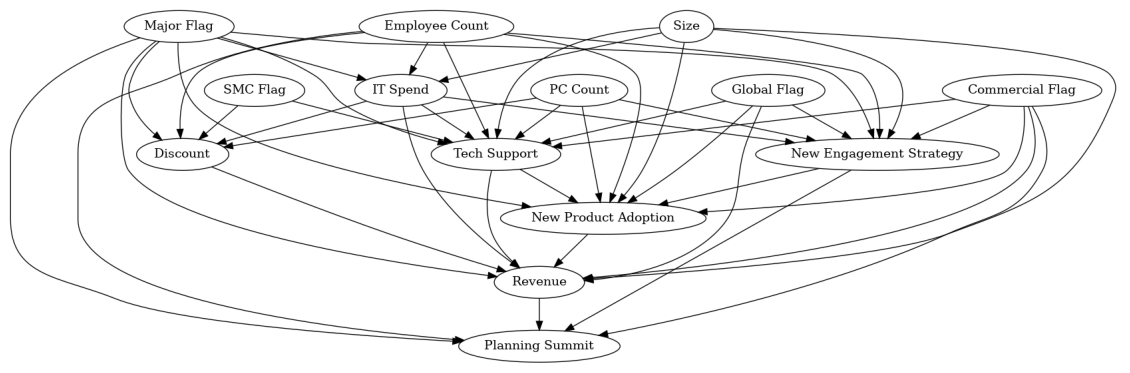

In [17]:
dowhy.gcm.util.plot(nx.relabel_nodes(networkx_graph, variable_name_dict), figure_size=(20, 20))

### Concluding graph discovery
The DECI model from Causica offers us a way to discover a causal graph from observational data. The learned graph can be iteratively refined by adding new graph constraints and retraining DECI to obtain a more realistic graph. 

# Treatment effect identification and estimation

The causal graph identifies the likely paths of connection between features. This next step will quantify the strength of those relationships between treatment and outcomes. Our tools estimate both the average treatment effect across all customers (ATE) and how these treatment effects vary across customer features. We refer to these personalized estimates as the conditional treatment effect (CATE) because they condition on customer features. If we are confident that we have included every feature that affects treatment intensity, we can also interpret these estimates as individual treatment effects (ITE), or the effect of treating a particular customer.

There are many tools to quantify causal effects. Many tools rely on an assumption of **unconfoundedness**, which means that we can measure and include in our estimation all features that have causal effects on both our outcome of interest and our treatment, or proxies for those features. These methods treat any variation in treatment that cannot be explained by the confounders as effectively random--a series of mini-experiments that can identify a causal effect. Other techniques do not make this unconfoundedness assumption and instead rely on other variation, such as an instrument that changes the probability of treatment but has no other effect on the outcome.

# Identify Causal Strategy

DoWhy tools can help users identify an appropriate causal model for their question and understand which confounders, or conditioning variables, they should include in their estimation. To identify an estimation approach, DoWhy needs to work with a causal graph that describes the problem space. This graph can be input directly by users based on their domain knowledge, including perhaps identifying features that may affect the outcome and treatment but cannot be measured. DoWhy can also work with an existing causal graph generated through discovery.

In this case, we begin with the Causica-derived graph `gml_string`. 

Once DoWhy identifies a valid identification approach, it calls the estimation automatically from EconML, passing an appropriate set of confounding variables. So, in this step, we must also specify some additional details about the kind of causal effect we want to estimate:
* In the graph uncovered in the first step, we can see that New Product Adoption acts as a **mediator** for the treatment Tech Support. Tech Support causes New Product Adoption, and in turn New Product Adoption causes changes to Revenue. There is also a direct causal path from Tech Support to Revenue. These relationships *require the user to decide exactly what effect they would like to measure*. The **direct effect** of Tech Support will quantify only the straight path from treatment to outcome, which is the effect of offering Tech Support *when the customer makes no changes to their product subscriptions*. An alternative is the **total effect**, which is the average effect of offering Tech Support in the sample, taking into account both the direct effect and the fact that tech support sometimes causes New Product Adoption, which further increases revenue. In this section, we call estimation for both options by specifying effect_type as "Direct" or "Total".

* In this example, DoWhy recommends a "back door" estimation approach, which relies on the unconfoundedness assumption, and selects all of the potential confounding variables except for Planning Summit, which was not identified as a confounder in the graph. In particular, DoWhy calls the Linear Double Machine Learning model from the EconML library for the estimation step.

* Finally, we specify two feature that we think may influence the size of treatment effects across customers: Global Flag and Size

In [8]:
# transformer that performs standard scaling on non-binary variables
ct = ColumnTransformer(
    [
        (
            'num_transformer', 
            StandardScaler(), 
            lambda df: pd.DataFrame(df).apply(pd.Series.nunique).loc[lambda df: df>2].index.tolist()
        )
    ], remainder='passthrough')

model_t = make_pipeline(ct, LogisticRegression(C=1300, max_iter=1000)) # model used to predict treatment
model_y = make_pipeline(ct, Lasso(alpha=20)) # model used to predict outcome

In [9]:
dml_causalmodel_dict = {}
dml_estimand_dict = {}
dml_estimate_dict = {}
dml_est_dict = {}

dml_results_df = pd.DataFrame()

effect_modifiers = ['Global Flag', 'Size']
treatment_columns = ["Tech Support", "Discount", "New Engagement Strategy"]
outcome = 'Revenue'

for ind, treatment in enumerate(treatment_columns):
    dml_causalmodel_dict[treatment] = {}
    dml_estimand_dict[treatment] = {}
    dml_estimate_dict[treatment] = {}
    dml_est_dict[treatment] = {}
    
    for effect_type in ['Direct', 'Total']:
        # identify
        dowhy_model = dowhy.CausalModel(data=multi_data, graph=gml_string, treatment=treatment, outcome=outcome, effect_modifiers=effect_modifiers)
        dml_causalmodel_dict[treatment][effect_type] = dowhy_model
        
        estimand_type = 'nonparametric-ate' if effect_type=='Total' else 'nonparametric-cde'
        identified_estimand = dowhy_model.identify_effect(method_name="maximal-adjustment", estimand_type=estimand_type)
        dml_estimand_dict[treatment][effect_type] = identified_estimand

        # estimate
        estimate = dowhy_model.estimate_effect(identified_estimand, 
                                               confidence_intervals=True,
                                               method_name="backdoor.econml.dml.LinearDML", 
                                               method_params={ 
                                                   'init_params': {
                                                       'model_t': model_t,
                                                       'model_y': model_y,
                                                       'linear_first_stages': True,
                                                       'discrete_treatment': True,
                                                       'cv': 3,
                                                       'mc_iters': 10
                                                   },
                                                   'fit_params' : {} 
                                               }
                                              )
        dml_estimate_dict[treatment][effect_type] = estimate

        # recover estimator and corresponding data
        est = estimate._estimator_object
        X = multi_data[effect_modifiers]
        dml_est_dict[treatment][effect_type] = est

        point_estimate = est.ate(X)
        lb, ub = est.ate_interval(np.array(X))
        row = {
            'Treatment': treatment,
            'Effect Type': effect_type,
            'Ground Truth': ground_truth_effects[f'{effect_type} Treatment Effect: {treatment}'].mean(axis=0), 
            'Point Estimate': point_estimate,
            'LB': lb,
            'UB': ub
        }

        dml_results_df = dml_results_df.append(row, ignore_index = True)
        
        # print first estimand and results as an example for illustration purposes
        if treatment == 'Tech Support' and effect_type == 'Direct':
            print(f'Showing results for {treatment}, {effect_type} Effect:\n')
            print(identified_estimand)
            display(est.summary())
            


Showing results for Tech Support, Direct Effect:

Estimand type: nonparametric-cde

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                                                              
───────────────(E[Revenue|PC Count,Employee Count,SMC Flag,Commercial Flag,Global Flag,Major Flag,New Product Adoption
d[Tech Support]                                                                                                       

                                                 
,IT Spend,New Engagement Strategy,Discount,Size])
                                                 
Estimand assumption 1, Unconfoundedness: If U→{Tech Support} and U→Revenue then P(Revenue|Tech Support,PC Count,Employee Count,SMC Flag,Commercial Flag,Global Flag,Major Flag,New Product Adoption,IT Spend,New Engagement Strategy,Discount,Size,U) = P(Revenue|Tech Support,PC Count,Employee Count,SMC Flag,Commercial Flag,Global Flag,Major Flag,New

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
Global Flag,242.605,366.08,0.663,0.508,-474.899,960.109
Size,0.022,0.003,8.921,0.0,0.017,0.027
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,4584.642,244.9,18.72,0.0,4104.646,5064.638


# Estimate Treatment Effects

### EconML

The table below summarizes the average direct and total treatment effects estimated using EconML's Linear DML model, called automatically by DoWhy in the previous step.

Unlike most real-world examples, we know the true causal effect in this case, so we include these ground truths in the table for comparison. 
* On average, offering a customer Tech Support directly increases annual revenue by a little over \$7,000. Because we use a finite and noisy data sample, the estimated point estimate is slightly different than the ground truth, but the 95\% confidence intervals, indicated by the upper and lower bound columns LB and UB, cover the true effect.
* On average, the total effect of offering tech support, including the indirect effect through increasing New Product Adoption, is even larger: just over \$8,000.
* Offering customers a Discount also has an important causal effect on revenue, about \$5,000 per year. In contrast, the New Engagement Strategy has no effect on revenue. The point estimate of the average treatment effect is small and negative, and based on the lower and upper bounds we cannot confidently reject that the effect is zero. In fact, looking at the ground truth, the new strategy has no effect on revenue--it is neither better nor worse than the current strategy.

In [10]:
dml_results_df.loc[lambda df: df['Effect Type'].eq('Direct') | df['Treatment'].eq('Tech Support')]

,Treatment,Effect Type,Ground Truth,Point Estimate,LB,UB
0,Tech Support,Direct,7301.071978,7090.889853,6763.521473,7418.258233
1,Tech Support,Total,8225.301978,8147.373133,7802.045044,8492.701222
2,Discount,Direct,5311.904945,4990.083496,4372.306195,5607.860797
4,New Engagement Strategy,Direct,0.000000,-112.867624,-362.360414,136.625165


### Causica

An alternative strategy is to estimate the treatment effects using Causica. This approach works in this case, since DoWhy determined that the **unconfoundedness** assumption holds. The DECI model in Causica estimates only the total treatment effect.

In [26]:
outcome = 'Revenue'
outcome_idx = dataset.variables.name_to_idx[outcome]
revenue_estimated_ate = {}
for treatment in treatment_columns:
    treatment_idx = dataset.variables.name_to_idx[treatment]
    ate = model.cate(
        intervention_idxs=np.array([treatment_idx]),
        intervention_values=np.array([1]),
        reference_values=np.array([0]),
        Nsamples_per_graph=25
    )
    revenue_estimated_ate[treatment] = ate[0][outcome_idx] * model.data_processor._cts_normalizers[1].scale_[-1]

In [27]:
revenue_estimated_ate

{'Tech Support': 7735.249328841498,
 'Discount': 4603.235739113766,
 'New Engagement Strategy': 418.1714562530155}

We can also compute confidence intervals for DECI ATE estimates by using the `sample` method: this uses samples from the interventional environment to build a confidence interval.

In [28]:
revenue_estimated_ate_ci = {}
for treatment in treatment_columns:
    treatment_idx = dataset.variables.name_to_idx[treatment]
    intervention_samples = model.sample(
        10000,
        intervention_idxs=np.array([treatment_idx]),
        intervention_values=np.array([1]),
    ).cpu().numpy()
    reference_samples = model.sample(
        10000,
        intervention_idxs=np.array([treatment_idx]),
        intervention_values=np.array([0]),
    ).cpu().numpy()
    estimated_var = intervention_samples[:, outcome_idx].var() + reference_samples[:, outcome_idx].var()
    std_err = np.sqrt(estimated_var / intervention_samples.shape[0])
    ate_estimate = (intervention_samples[:, outcome_idx] - reference_samples[:, outcome_idx]).mean()
    std_err *= model.data_processor._cts_normalizers[1].scale_[-1]
    ate_estimate *= model.data_processor._cts_normalizers[1].scale_[-1]
    revenue_estimated_ate_ci[treatment] = (ate_estimate - 2 * std_err, ate_estimate + 2 * std_err)

In [29]:
revenue_estimated_ate_ci

{'Tech Support': (7591.69249338639, 8527.895307596817),
 'Discount': (4117.925289304451, 5042.4139871800535),
 'New Engagement Strategy': (-511.5285675621403, 479.29800629556894)}

This table compares the average total treatment effects from Causica and EconML, along with the ground truth. Reassuringly, the estimates from both methods are close to each other, and to the ground truth.

In [ ]:
# gather the causica results into a dataframe
causica_results_df = (
    pd.DataFrame.from_dict(revenue_estimated_ate, orient='index')
    .pipe(
        lambda df:
        pd.concat([
            df,
            pd.DataFrame.from_dict(revenue_estimated_ate_ci, orient='index')
        ], axis = 1)
    )
    .reset_index()
    .set_axis(['Treatment', 'Point Estimate', 'LB', 'UB'], axis = 1)
    .assign(
        Method='Causica',
        Effect_Type='Total',
        Ground_Truth=dml_results_df.loc[lambda df: df['Effect Type'].eq('Total'), 'Ground Truth'].values
    )
    .rename(columns = {'Effect_Type': 'Effect Type', 'Ground_Truth': 'Ground Truth'})
)

# combine with DoWhy/EconML results and display
combined_results = (
    dml_results_df.loc[lambda df: df['Effect Type'].eq('Total')]
    .assign(Method='DoWhy/EconML')
    .pipe(
        lambda df: 
        pd.concat([
            df,causica_results_df
        ])
    )
    .sort_values('Treatment')
)
combined_results

,Treatment,Effect Type,Ground Truth,Point Estimate,LB,UB,Method
3,Discount,Total,5311.904945,4959.143859,4346.747524,5571.540195,DoWhy/EconML
1,Discount,Total,5311.904945,4603.235739,4117.925289,5042.413987,Causica
5,New Engagement Strategy,Total,0.000000,-102.759242,-459.976971,254.458487,DoWhy/EconML
2,New Engagement Strategy,Total,0.000000,418.171456,-511.528568,479.298006,Causica
1,Tech Support,Total,8225.301978,8147.373133,7802.045044,8492.701222,DoWhy/EconML
0,Tech Support,Total,8225.301978,7735.249329,7591.692493,8527.895308,Causica


# Test Estimate Robustness

In [15]:
treatment = 'Tech Support'
effect_type = 'Direct'

# extract relevant classes from our results dicts
dowhy_model = dml_causalmodel_dict[treatment][effect_type]
identified_estimand = dml_estimand_dict[treatment][effect_type]
estimate = dml_estimate_dict[treatment][effect_type]

#### Add random common cause

How robust are our estimates to adding an uncorrelated confounder? We use DoWhy to test this!

#### Add Unobserved Common Cause 

How robust are our estimates to unobserved confounders? Since we assume unconfoundedness, adding an unobserved confounder might bias the estimates. We use DoWhy to show this!

#### Replace Treatment with a Random (Placebo) Variable

What happens our estimates if we replace the treatment variable with noise? Ideally, the average effect would be close to 0. We use DoWhy to investigate!

#### Remove a Random Subset of the Data
 
Do we recover similar estimates on subsets of the data? This speaks to the ability of our chosen estimator to generalize well. We use DoWhy to investigate this!

####  Using a Dummy Outcome

If we artificially generate the outcome as a function of the confounders, what happens to our estimate of the causal effect? We use DoWhy to investigate.

                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


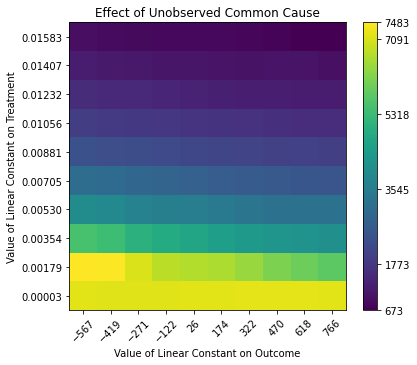

                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.
                 Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


In [19]:
# We keep the num_simulations argument small here for quick results; recommended value of num_simulations is 100 or higher
res_random = dowhy_model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", num_simulations=20, n_jobs=2)

res_unobserved = dowhy_model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
    effect_fraction_on_treatment=0.05, effect_fraction_on_outcome=0.05)

res_placebo = dowhy_model.refute_estimate(identified_estimand, estimate,
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=20, n_jobs=2
)

res_subset = dowhy_model.refute_estimate(identified_estimand, estimate,
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=20, n_jobs=2)


coefficients = np.array([10, 0.02])
bias = 1000
def linear_gen(df):
    y_new = np.dot(df[['W0','W1']].values,coefficients) + bias
    return y_new

ref = dowhy_model.refute_estimate(identified_estimand,
                           estimate,
                           method_name="dummy_outcome_refuter",
                           outcome_function=linear_gen
                           )
res_dummy_outcome = ref[0]



In [20]:
refutation_df = pd.DataFrame()
for refutation_result in [res_random, res_unobserved, res_placebo, res_subset, ref[0]]:
    
    row = {
        'Refutation Type': refutation_result.refutation_type,
        'Estimated Effect': refutation_result.estimated_effect,
        'New Effect': refutation_result.new_effect,
        'Refutation Result (p value)': refutation_result.refutation_result['p_value'] if refutation_result.refutation_result else None,
    }
    
    refutation_df = refutation_df.append(row, ignore_index = True)
refutation_df

,Refutation Type,Estimated Effect,New Effect,Refutation Result (p value)
0,Refute: Add a random common cause,7090.889853,7092.141948,0.442211
1,Refute: Add an Unobserved Common Cause,7090.889853,"(673.2739093114709, 7482.788418743075)",None
2,Refute: Use a Placebo Treatment,7090.889853,12.938801,0.37267
3,Refute: Use a subset of data,7090.889853,7089.4129,0.491168
4,Refute: Use a Dummy Outcome,0.000000,0.001558,0.94


# Make Policy Recommendations

In this section, we use EconML tools to visualize differences in conditional average treatment effects across customers and select an optimal investment plan for each customer.

In order to decide whether to offer each investment to the customer, we need to know the cost of providing the incentive as well as the benefits of doing so. In this step we define a cost function to specify how expensive it would be to provide each kind of incentive to each customer. In other data samples you can define these costs as a function of customer features, upload a matrix of costs, or set constant costs for each treatment (the default is zero).



In [21]:
# Define cost function
def cost_fn_interaction(multi_data):
    t1_cost = multi_data[["PC Count"]].values * 100
    t2_cost = np.ones((multi_data.shape[0], 1)) * 7000
    return np.hstack([t1_cost, t2_cost, t1_cost + t2_cost])

In [22]:
# Transform T to one-dimensional array with consecutive integer encoding
def treat_map(t):
    return np.dot(t, 2 ** np.arange(t.shape[0]))

# define input variables for composite treatment model
collider_column = 'Planning Summit'
X_policy = multi_data[effect_modifiers + ['PC Count']]
W_with_mediator = multi_data.drop(
    columns = treatment_columns + [outcome] + 
    effect_modifiers + [collider_column])
Y = multi_data[outcome]

composite_treatment = multi_data[['Tech Support', 'Discount']].apply(treat_map, axis = 1).rename('Composite Treatment')
composite_model = LinearDML(
    model_t = model_t,
    model_y = model_y,
    discrete_treatment=True, 
    linear_first_stages=True,
    mc_iters=10
)
composite_model.fit(Y=Y, T=composite_treatment, X=X_policy, W=W_with_mediator)

#### Deriving a Rule for Allocating Investments

EconML's policy tree interpreter fits a regression tree on the set of conditional average treatment effects estimated earlier. The interpreter divides the sample into groups that all respond similarly to treatments, and recommends the optimal treatment for each group, or leaf. This same rule can be applied to pick treatments for new samples of customers with the same characteristics. Set the depth option to allow the intpreter to create more or fewer groups (a depth of 2 creates a maximum of 4 groups).

In [23]:
est = SingleTreePolicyInterpreter(random_state=1,
                     min_impurity_decrease=0.1,
                     min_samples_leaf=40,
                     max_depth=2)

est.interpret(composite_model, X_policy, sample_treatment_costs = cost_fn_interaction(multi_data))

Observe recommended treatment policies

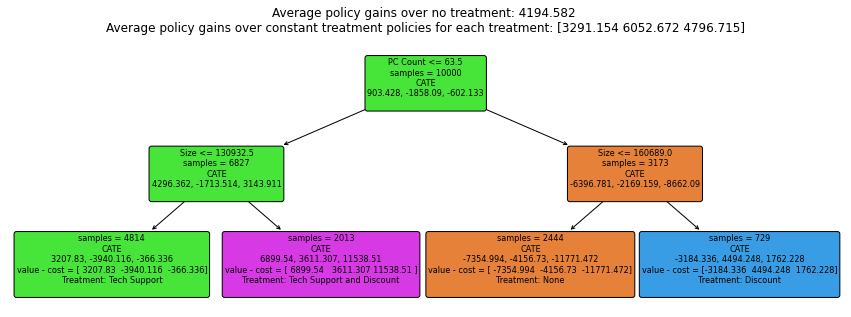

In [24]:
plt.figure(figsize=(15, 5))
est.plot(treatment_names=['None', 'Tech Support', 'Discount', 'Tech Support and Discount'], feature_names=['Global Flag', 'Size', 'PC Count'])

#### Individualized policy recommendations 

For our current sample of customers, we can also identify the best treatment plan for each individual customer based on their CATE. We use the model's `const_marginal_effect` method to find the counterfactual treatment effect for each possible treatment. We then subtract the treatment cost and choose the treatment which the highest return. That is the recommended policy.

To visualize this output, we plot each customer based on their PC count and past revenue, the most important determinants of treatment according to the tree interpreter, and color code them based on recommended treatment.

In [25]:
models = [dml_est_dict[key]['Direct'] for key in dml_est_dict if key != 'New Engagement Strategy']
effects = np.hstack([model.const_marginal_effect(X) for model in models])
effects_with_interaction = np.hstack([effects, effects.sum(axis=1, keepdims=True)])
net_effects = effects_with_interaction - cost_fn_interaction(multi_data)
net_effects_with_control = np.hstack([np.zeros(shape = (X.shape[0], 1)), net_effects])

In [26]:
recommended_T = net_effects_with_control.argmax(axis = 1)

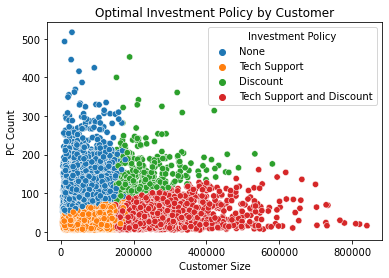

In [27]:
all_treatments = np.array(['None', 'Tech Support', 'Discount', 'Tech Support and Discount'])

ax1 = sns.scatterplot(
    x=multi_data['Size'],
    y=multi_data["PC Count"],
    hue=all_treatments[recommended_T],
    hue_order=all_treatments,
    cmap="Dark2",
    s=40,
)
plt.legend(title="Investment Policy")
plt.setp(
    ax1,
    xlabel="Customer Size",
    ylabel="PC Count",
    title="Optimal Investment Policy by Customer",
)
plt.show()

# Appendix

### Conditional average treatment effect with Causica

Causica also estimates conditional average treatment effects. In this appendix we illustrate how to collecte CATE estimates and policy recommendations for individual observations using the Causica causal effect estimates.

Let's repeat this analysis, but conditional on the company having Size 100,000. DECI can estimate the conditional average treatment effect for such a partner.

In [ ]:
# We need to convert the conditioning value correctly
condition_idx = dataset.variables.name_to_idx["Size"]
condition_value = np.zeros((1, model.processed_dim_all))
condition_value[0, condition_idx] = 100000
condition_value = model.data_processor.process_data(condition_value)
condition_value = condition_value[0, [condition_idx]]

In [ ]:
revenue_estimated_cate = {}
model.cate_rff_n_features = 100
for treatment in treatment_columns:
    treatment_idx = dataset.variables.name_to_idx[treatment]
    cate = model.cate(
        intervention_idxs=np.array([treatment_idx]),
        intervention_values=np.array([1]),
        reference_values=np.array([0]),
        conditioning_idxs=np.array([condition_idx]),
        conditioning_values=condition_value,
        effect_idxs=np.array([outcome_idx]),
        Nsamples_per_graph=10
    )
    
    revenue_estimated_cate[treatment] = cate[0][0] * model.data_processor._cts_normalizers[1].scale_[-1]

In [ ]:
revenue_estimated_cate

{'Tech Support': 6295.509751301921,
 'Discount': 3656.323631018368,
 'New Engagement Strategy': 82.42726709820107}

### Estimate individual treatment effects and best actions

Finally, Causica can estimate *individual* treatment effects: the difference between giving and not giving the engagement to a specific customer. We can then use these ITEs to suggest the best action to take for each customer.

In [ ]:
revenue_estimated_ite = {}
for treatment in treatment_columns:
    treatment_idx = dataset.variables.name_to_idx[treatment]
    ite = model.ite(
        model.data_processor.process_data(dataset._train_data),
        intervention_idxs=np.array([treatment_idx]),
        intervention_values=np.array([1]),
        reference_values=np.array([0]),
    )
    revenue_estimated_ite[treatment] = ite[0][:, outcome_idx] * model.data_processor._cts_normalizers[1].scale_[-1]

In [ ]:
revenue_estimated_ite

{'Tech Support': array([ 8247.22621216,  5272.54416598,  8572.76967538, ...,
         7674.13963873,  4927.32650846, 10922.89660965]),
 'Discount': array([11309.31470967, -1638.36874156,  5924.03726934, ...,
         6864.37575169,   492.19615884,  8788.66285986]),
 'New Engagement Strategy': array([0., 0., 0., ..., 0., 0., 0.])}

#### Find the optimal action for each customer
The optimal action is the one with the largest ITE for that customer. This function can also incorporate budget constraints (e.g. placing a budget constraint on the Discount engagement). Here we illustrate optimal actions without a budget.

In [ ]:
assignments, optimal_values = model.posterior_expected_optimal_policy(
    model.data_processor.process_data(dataset._train_data[0:250, :]),
    intervention_idxs=np.array([dataset.variables.name_to_idx[name] for name in treatment_columns]),
    objective_function=lambda *args: model.ite(*args)[0][:, outcome_idx],
    reference_intervention=np.array([0, 0, 0])
)

In [ ]:
total_assigned = assignments.sum(0).round()

In [ ]:
for i, name in enumerate(treatment_columns):
    print(f"{total_assigned[i]} customers assigned treatment {name}")

218.0 customers assigned treatment Tech Support
32.0 customers assigned treatment Discount
0.0 customers assigned treatment New Engagement Strategy


#### Advanced Identification: With unobserved confounders

In [53]:
with open('true_graph_gml_string.txt', 'r') as f:
    trueg_string = f.read()

In [54]:
temp_graph = nx.parse_gml(trueg_string)

old graph

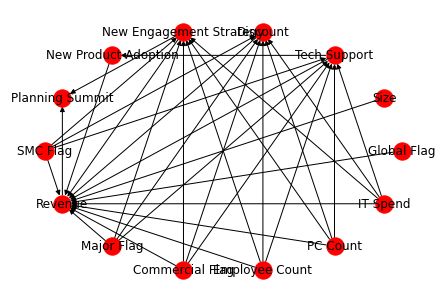

In [55]:
variable_name_dict = {var: var for (i, var) in enumerate(multi_data.columns)}
nx.draw_shell(temp_graph, arrows=True, labels = variable_name_dict,  node_color="red")

add nodes/edges for unobserved confounder

In [56]:
temp_graph.add_node('UNOBSERVED CONFOUNDER')
temp_graph.add_edge('UNOBSERVED CONFOUNDER', 'Tech Support')
temp_graph.add_edge('UNOBSERVED CONFOUNDER', 'Revenue')

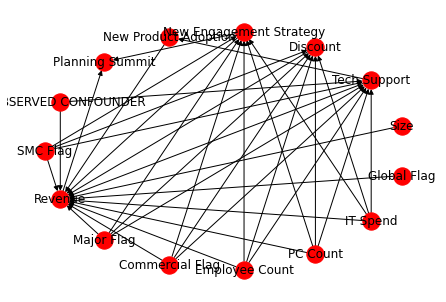

In [57]:
variable_name_dict = {var: var for (i, var) in enumerate(multi_data.columns)}
variable_name_dict['UNOBSERVED CONFOUNDER'] = 'UNOBSERVED CONFOUNDER'
nx.draw_shell(temp_graph, arrows=True, labels = variable_name_dict,  node_color="red")

In [58]:
temp_labeled_graph = nx.relabel_nodes(temp_graph, variable_name_dict, copy=False)
temp_gml_string = "".join(nx.generate_gml(temp_labeled_graph))

Notice backdoor identification fails with unobserved confounder

In [59]:
dowhy_model = dowhy.CausalModel(data=multi_data, graph=temp_gml_string, treatment=treatment, outcome=outcome, effect_modifiers=effect_modifiers)
identified_estimand = dowhy_model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

